In [112]:
from IPython.display import HTML
HTML('''<script> code_show=true;  
function code_toggle() {
 if (code_show){  $('div.input').hide(); 
 } else {  $('div.input').show();  }
 code_show = !code_show
}
$( document ).ready(code_toggle); </script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
def read_stock(stock_name):
    fname = ("table_%s.csv" % stock_name)
#     print(fname)
    data1 = pd.read_csv(fname, names=['date', 'foo', 'o', 'h', 'l', 'c', 'v'], header=False, parse_dates=['date'])
    return data1

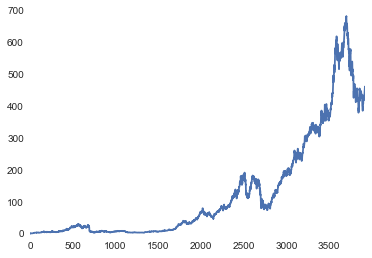

In [6]:
read_stock("aapl")['o'].plot()

In [191]:
def compute_scenarios(stock, λ = 0.06):
    _com = (1 - λ) / λ
    
    log_returns = np.log( stock / stock.shift(1))
    log_returns = log_returns.ix[1:]
    
    _std = pd.ewmstd( log_returns, com=_com)
    _mu = pd.ewma( log_returns, com=_com)

    residuals = ( log_returns / _std )
    residuals = residuals.ix[20:]

    σ = _std[_std.last_valid_index()]
    scenario_shifts = np.exp(residuals * σ)
    neutral_scenario = stock.ix[stock.last_valid_index()]
    scenarios = neutral_scenario * scenario_shifts
    
    return scenarios, neutral_scenario, scenario_shifts


def compute_logreturns_np(stock):
    return np.log( np.divide(stock[1:], stock[:-1]) )

def compute_scenarios_np(stock, λ = 0.06, number_of_scenarios=752):
    _com = (1 - λ) / λ
    
    last_index = len(stock) - 1
    first_index = last_index - number_of_scenarios
    log_returns = compute_logreturns_np(stock)
    
    _std = pd.ewmstd( log_returns, com=_com, ignore_na=True)
    _std = _std[first_index:last_index]
    _mu  = pd.ewma( stock, com=_com, ignore_na=True)
    _mu  = _mu[first_index:last_index]

    ξ = np.divide(log_returns[first_index:last_index], _std)
    neutral_scenario, σ = stock[-1], _std[-1]
    scenario_shifts = np.exp(ξ * σ)
    scenarios = neutral_scenario * scenario_shifts
    
    return scenarios, neutral_scenario, log_returns[-number_of_scenarios:], _std, _mu


def compute_var(scenarios, neutral_scenario, level=99.):
    pnls = scenarios - neutral
    return - np.percentile(pnls, 100-level, interpolation='linear')

def f(stock, λ=0.06):
    scenarios, neutral, log_returns, σ = compute_scenarios_np(stock)
    var = compute_var(scenarios, neutral)
    sns.distplot(neutral - scenarios);
    return np.mean(scenarios)

def plot_all(scenarios, neutral_scenario, log_returns, σ, ξ=None):
#     com = (1 - _lambda) / _lambda
    ig, axes = sns.plt.subplots(nrows=4, ncols=1, figsize=(12,8))
    axes[0].set_title('Log returns')
    sns.distplot( log_returns,ax=axes[0]) #, label='log-returns')
    sns.distplot( np.exp(log_returns), ax=axes[1] )
    axes[2].set_title('Estimated volatility')
    sns.tsplot( σ, legend=True, ax=axes[2]) #, label='std')
#     sns.tsplot( scenarios-neutral, legend=True, ax=axes[3]) #, label='std')
    sns.distplot( scenarios, ax=axes[3] )

def f1(stock, λ=0.06):
    scenarios, neutral, log_returns, σ = compute_scenarios_np(stock)
#     plot_all(scenarios, neutral, log_returns, σ)
    var = compute_var(scenarios, neutral)
#     sns.distplot(neutral - scenarios);
    return np.mean(scenarios)

In [190]:
from IPython.html.widgets import *
def g(x):
    f1(stock.ix[x-1000:x].values)
    print(stock.ix[x])
interact(g, x=(1001,3924,10));


ValueError: too many values to unpack (expected 4)

In [6]:
from bokeh.plotting import *


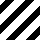
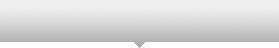
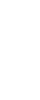
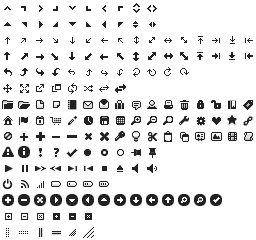
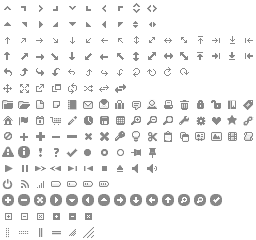
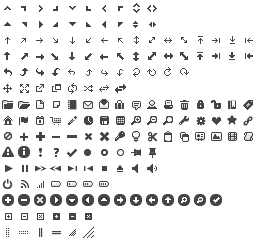
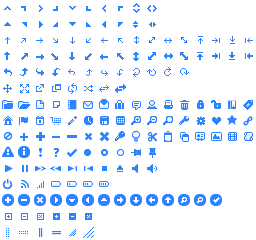
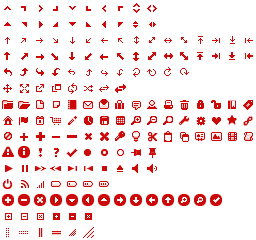
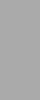
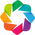
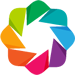
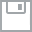
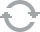
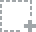
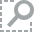
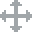
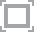
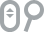

In [7]:
output_notebook()

In [204]:
x = np.arange(752)
y = np.random.rand(752)
hist, edges = np.histogram(scenarios, density=True, bins=50)

source = ColumnDataSource(data=dict(x=x, y=y,
                                    hist=hist, edges=edges,
                                    xx=np.append(x,x[::-1]), yy=np.append(y, y[::-1]),
                                   x_var = 0, var = 0))


@interact(x=(1001,3924,10), λ=(0.01, 0.99, 0.01), α=(0.01, 0.99, 0.01))
def update(x, λ, α):
    s = stock.ix[x-1000:x].values
    scenarios, neutral, log_returns, σ, μ = compute_scenarios_np(s, λ=λ)
    source.data['y'] = scenarios - neutral
    var = compute_var(scenarios, neutral, level=α)
    
    hist, edges = np.histogram(scenarios - neutral, density=True, bins=50)
    
    source.data['top'] = hist
    source.data['left'] = edges[:-1]
    source.data['right'] = edges[1:]
    source.data['bottom'] = 0
    source.data['xvar'] = [source.data['x'][0], source.data['x'][-1]]
    source.data['var'] = var
    print(var)
    
    source.data['yy'] = np.append( np.multiply(s[-752:], np.exp(1 - σ)), np.multiply(s[-752:], 1 + σ)[::-1])
    source.push_notebook()

p = figure(title="simple line example", plot_height=300, plot_width=600)
# p.line('x', 'y', color="#2222aa", line_width=1, source=source, name="foo")
p.patch('xx', 'yy', source=source, color='#7570B3', fill_alpha=0.2)
p.line('x_var', 'var', source=source, line_width=1, color='#444444', name="var")

def stylize(p):
    p.title_text_font_size = "8pt"
    p.axis.major_tick_line_color = None
    p.axis[0].ticker.num_minor_ticks = 0
    p.axis[1].ticker.num_minor_ticks = 0


p1 = figure(title="Returns Histogram", plot_height=300, plot_width=600)
p1.quad(top=[0], bottom=0, left=[0], right=[0],
        fill_color="#036564", line_color="#033649",
        alpha=0.5,
        source=source)



stylize(p)
stylize(p1)


318.215935251


In [205]:
show(gridplot([[p],[p1]]))

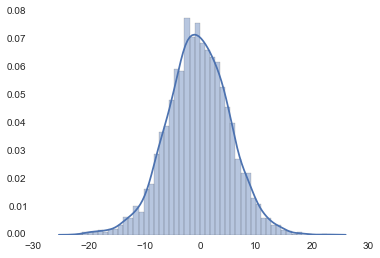

In [10]:
stock = read_stock("aapl")['o']
scenarios, neutral, shifts = compute_scenarios(stock)
sns.distplot(neutral-scenarios);

In [10]:
%%timeit
scenarios, neutral, shifts = compute_scenarios(stock)
var = compute_var(scenarios, neutral)

100 loops, best of 3: 2.56 ms per loop


In [122]:
p.patch?

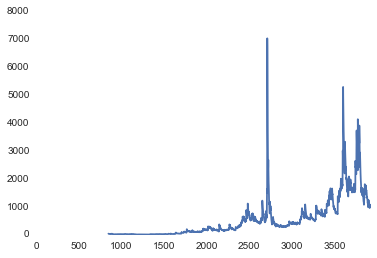

In [107]:
sns.tsplot(hist_var)

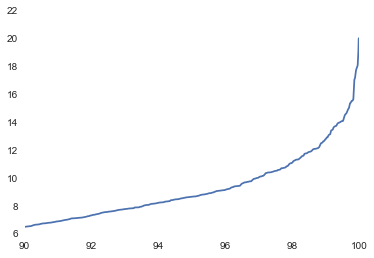

In [11]:
x = np.arange(90,99.99, 0.01)
sns.plt.plot(x, [- np.percentile(scenarios - neutral, 100-l, interpolation='linear') for l in x]);

In [113]:
# %%timeit
hist_var = pd.stats.moments.rolling_apply( stock, 1000, f1, min_periods=850) #, freq='100D')
# sns.plt.plot( pd.stats.moments.rolling_apply( stock, 1000, len, min_periods=850))
hist_var

NameError: name '_lambda' is not defined

In [150]:
upperband = np.random.random_integers(100, 150, size=100)
lowerband = upperband - 100
x_data = np.arange(1, 101)

band_x = np.append(x_data, x_data[::-1]) 
band_y = np.append(lowerband, upperband[::-1])  

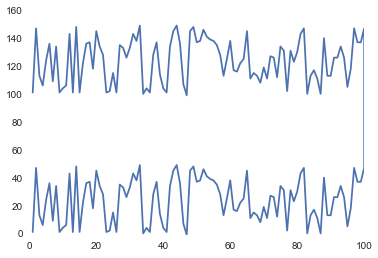

In [158]:
sns.plt.plot(band_x, band_y)

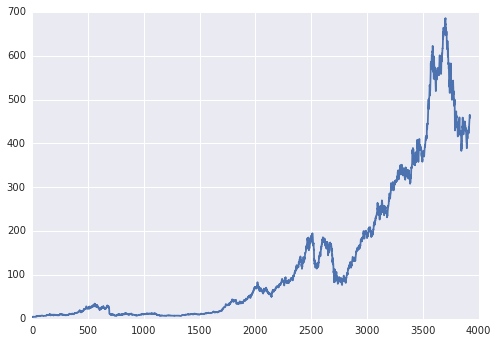

In [281]:
sns.plt.plot(stock)

In [135]:
p.patch?

In [129]:
from IPython.core.display import HTML
import requests
def css_styling():
    styles = requests.get('http://nbviewer.ipython.org/github/barbagroup/CFDPython/blob/master/styles/custom.css').text
    print(styles)
    return HTML(styles)
css_styling()

<link href='http://fonts.googleapis.com/css?family=Fenix' rel='stylesheet' type='text/css'>
<link href='http://fonts.googleapis.com/css?family=Alegreya+Sans:100,300,400,500,700,800,900,100italic,300italic,400italic,500italic,700italic,800italic,900italic' rel='stylesheet' type='text/css'>
<link href='http://fonts.googleapis.com/css?family=Source+Code+Pro:300,400' rel='stylesheet' type='text/css'>
<style>
    @font-face {
        font-family: "Computer Modern";
        src: url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunss.otf');
    }
    div.cell{
        width:800px;
        margin-left:16% !important;
        margin-right:auto;
    }
    h1 {
        font-family: 'Alegreya Sans', sans-serif;
    }
    h2 {
        font-family: 'Fenix', serif;
    }
    h3{
		font-family: 'Fenix', serif;
        margin-top:12px;
        margin-bottom: 3px;
       }
	h4{
		font-family: 'Fenix', serif;
       }
    h5 {
        font-family: 'Alegreya Sans', sans-serif;
    }	   
    div.te